# Markovian model of SBB railways

In [1]:
import math
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

## Loading the dataset

[See the medium article 'SBB trains delay'](https://medium.com/@christopher.hogendijk/sbb-trains-delay-4b1e23f3bd15)

In [2]:
# Clean data contains every "stop" for a year for the IC, IR and RE trains operated by SBB
data = pd.read_pickle('data/istdaten/data_clean_201807-201906.pkl')

In [3]:
# Calculate dwell times
data['DWELL'] = (
    pd.to_datetime(data['AB_PROGNOSE'], format="%d.%m.%Y %H:%M:%S") -
    pd.to_datetime(data['AN_PROGNOSE'], format="%d.%m.%Y %H:%M:%S")).dt.total_seconds().fillna(0)

In [4]:
# Collect features
features = []

In [5]:
# One feature per day
for day in data['BETRIEBSTAG'].unique():
    feature = data[data['BETRIEBSTAG'] == day]
    # Reset index
    feature = feature.reset_index()
    feature = feature.drop(columns=['index'])
    features.append(feature)

In [6]:
# Example of one route
index = 30
features[index].loc[features[index]['LINIEN_ID']==992]

BETRIEBSTAG LINIEN_ID LINIEN_TEXT VERKEHRSMITTEL_TEXT ZUSATZFAHRT_TF  \
13759  31.07.2018       992        IC61                  IC          False   
13760  31.07.2018       992        IC61                  IC          False   
13761  31.07.2018       992        IC61                  IC          False   
13762  31.07.2018       992        IC61                  IC          False   
13763  31.07.2018       992        IC61                  IC          False   

      FAELLT_AUS_TF HALTESTELLEN_NAME      ANKUNFTSZEIT          AN_PROGNOSE  \
13759         False    Interlaken Ost               NaN                  NaN   
13760         False   Interlaken West  31.07.2018 23:03  31.07.2018 23:07:31   
13761         False             Spiez  31.07.2018 23:21  31.07.2018 23:25:39   
13762         False              Thun  31.07.2018 23:32  31.07.2018 23:35:27   
13763         False              Bern  31.07.2018 23:52  31.07.2018 23:55:33   

      AN_PROGNOSE_STATUS      ABFAHRTSZEIT          AB_PROGNOSE  \
13759           PROGNOSE  31.07.2018 23:00  31.07.2018 23:04:02   
13760               REAL  31.07.2018 23:05  31.07.2018 23:09:09   
13761               REAL  31.07.2018 23:22  31.07.2018 23:26:40   
13762               REAL  31.07.2018 23:33  31.07.2018 23:37:55   
13763               REAL               NaN                  NaN   

      AB_PROGNOSE_STATUS DURCHFAHRT_TF DELAY_AN DELAY_AB  DWELL  
13759               REAL         False      NaT 00:04:02    0.0  
13760               REAL         False 00:04:31 00:04:09   98.0  
13761               REAL         False 00:04:39 00:04:40   61.0  
13762               REAL         False 00:03:27 00:04:55  148.0  
13763           PROGNOSE         False 00:03:33      NaT    0.0

## Model construction

In [7]:
# Collect starting vectors
initials = []
# Collect transition matrices
matrices = []
# Collect states
states = []

for feature in features[:2]:
    print(' ')
    # Dictionary of long-distance stations
    dic = {'station': np.unique(feature['HALTESTELLEN_NAME'])}
    stations = pd.DataFrame(dic)
    states.append(stations)

    # Size of the matrix
    n = stations.shape[0]
    print('n =', n)
    # Initialize a n*n transition matrix
    s = (n, n)
    matrix = pd.DataFrame(np.zeros(s))
    # Initialize a n*1 initial start vector
    t = (n)
    Initial = pd.DataFrame(np.zeros(t))

    print(feature['BETRIEBSTAG'].unique()[0])
    for route in feature['LINIEN_ID'].unique():
        stops = feature.loc[feature['LINIEN_ID'] == route]['HALTESTELLEN_NAME']
        if len(stops) > 1:
            pos_i = stations.loc[stations['station'] == stops.iloc[0]].index[0]
            Initial.iloc[pos_i] += 1
            for i in range(len(stops) - 1):
                temp = feature.loc[feature['LINIEN_ID'] == route]
                pos1 = stations.loc[stations['station'] == stops.iloc[i]].index[0]
                pos2 = stations.loc[stations['station'] == stops.iloc[i + 1]].index[0]
                # Calculate running times
                running = pd.to_datetime(
                    temp.loc[temp['HALTESTELLEN_NAME'] == stops.iloc[i + 1]]
                    ['AN_PROGNOSE'].values[0],
                    format="%d.%m.%Y %H:%M:%S") - pd.to_datetime(
                        temp.loc[temp['HALTESTELLEN_NAME'] == stops.iloc[i]]
                        ['AB_PROGNOSE'].values[0],
                        format="%d.%m.%Y %H:%M:%S")
                # Add running times as transition
                if math.isnan(running.seconds):
                    matrix.iloc[pos1, pos2] += 0
                else:
                    matrix.iloc[pos1, pos2] += running.seconds
                # Calculate dwell times
                dwell = temp.loc[temp['HALTESTELLEN_NAME'] == stops.iloc[i]]['DWELL'].values[0]
                # Add dwell times as self-loop
                matrix.iloc[pos1, pos1] += dwell

    # Fill in the vectors
    Initial_dist = Initial.div(Initial.sum(axis=0), axis=1)
    Initial_dist.columns = ['Prob']
    Initial_dist['Station'] = dic['station']
    initials.append(Initial_dist)

    # Fill in the matrices
    tran_matrix = matrix
    tran_matrix.columns = dic['station']
    tran_matrix['Index'] = dic['station']
    tran_matrix = tran_matrix.set_index('Index')
    matrices.append(tran_matrix)

 
n = 186
01.07.2018
 
n = 198
02.07.2018


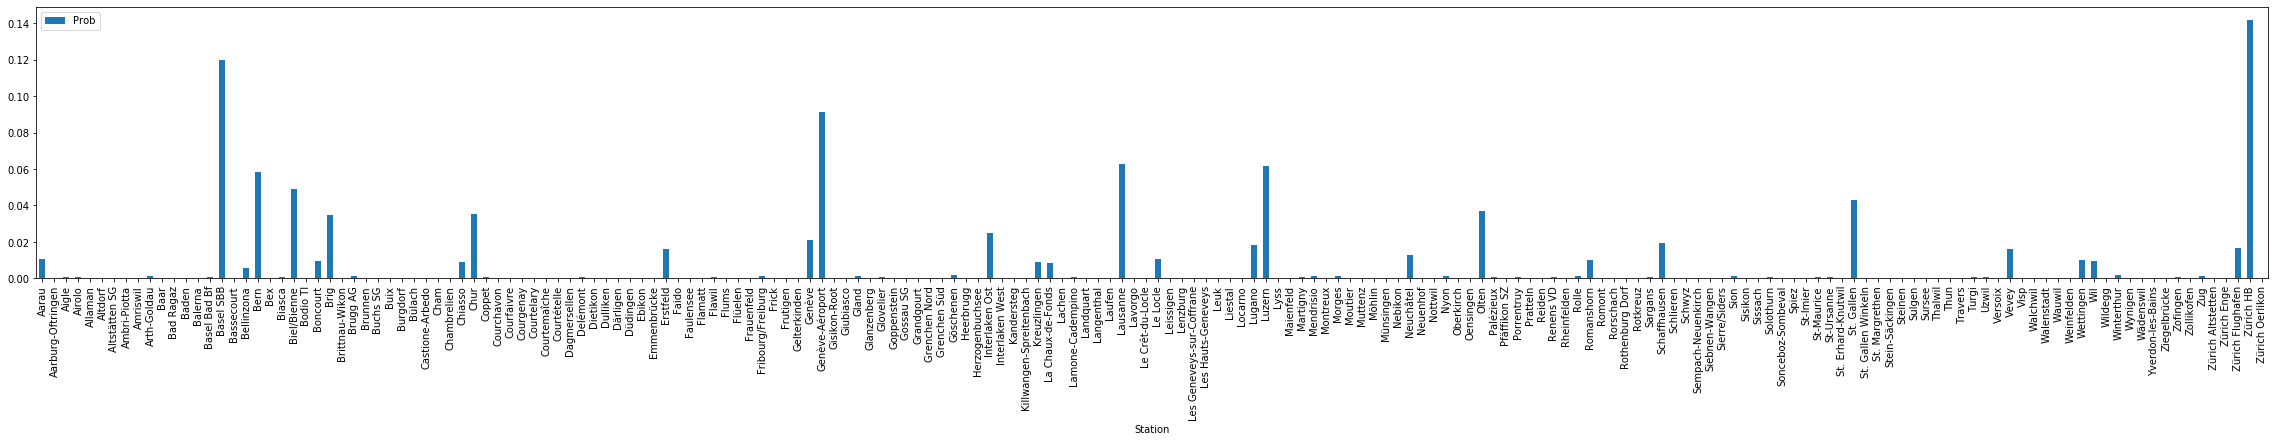

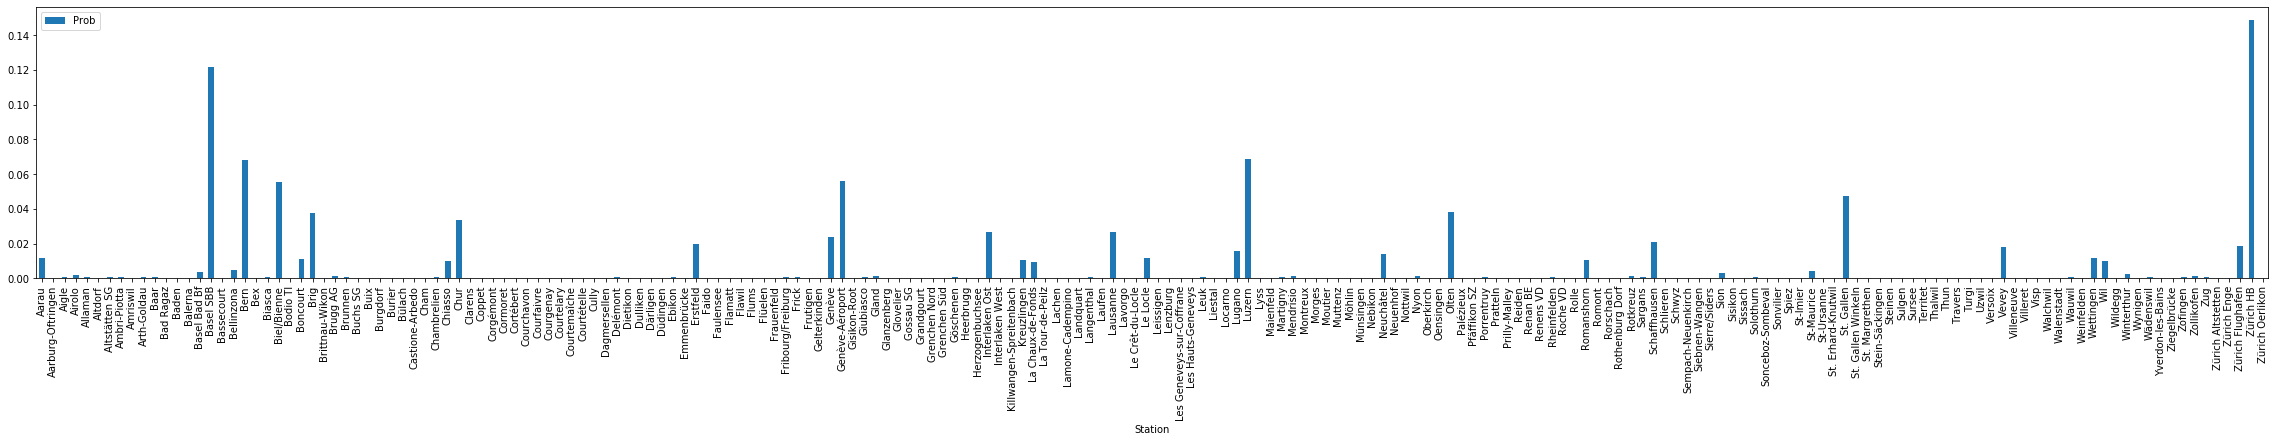

In [8]:
# The most frequent starting stations
for initial in initials:
    initial.plot.bar(x='Station', y='Prob', figsize=(40, 5))

In [9]:
# Make a deep copy of discrete matrices
TMs = []
for matrix in matrices:
    TM = matrix.copy(deep=True)
    TMs.append(TM)

In [10]:
# Now convert to probabilities
for i, TM in enumerate(TMs):
    eps = .001
    count = 0
    for row in TM.values:
        s = sum(row)
        k = 0
        if sum(f > 0 for k, f in enumerate(row)) == 1 and count==k:
            print('Absorbing state at', states[i].iloc[count]['station'], count, '\n')
            row[:] = eps
            row[count] = 1.0
            row[:] = [f/sum(row) for f in row]
        if s == 0:
            print('Singularity at', states[i].iloc[count]['station'], count, '\n')
            row[:] = eps
            row[count] = 1.0
            row[:] = [f/sum(row) for f in row]
        else:
            row[:] = [f/sum(row) for f in row]
        TM.values[count]=row
        count+=1

Singularity at Chambrelien 34 

Singularity at Le Crêt-du-Locle 92 

Singularity at Le Locle 93 

Singularity at Les Geneveys-sur-Coffrane 96 

Singularity at Les Hauts-Geneveys 97 

Singularity at Locarno 100 

Singularity at Travers 160 

Singularity at Zollikofen 179 

Singularity at Locarno 105 

Singularity at Travers 170 



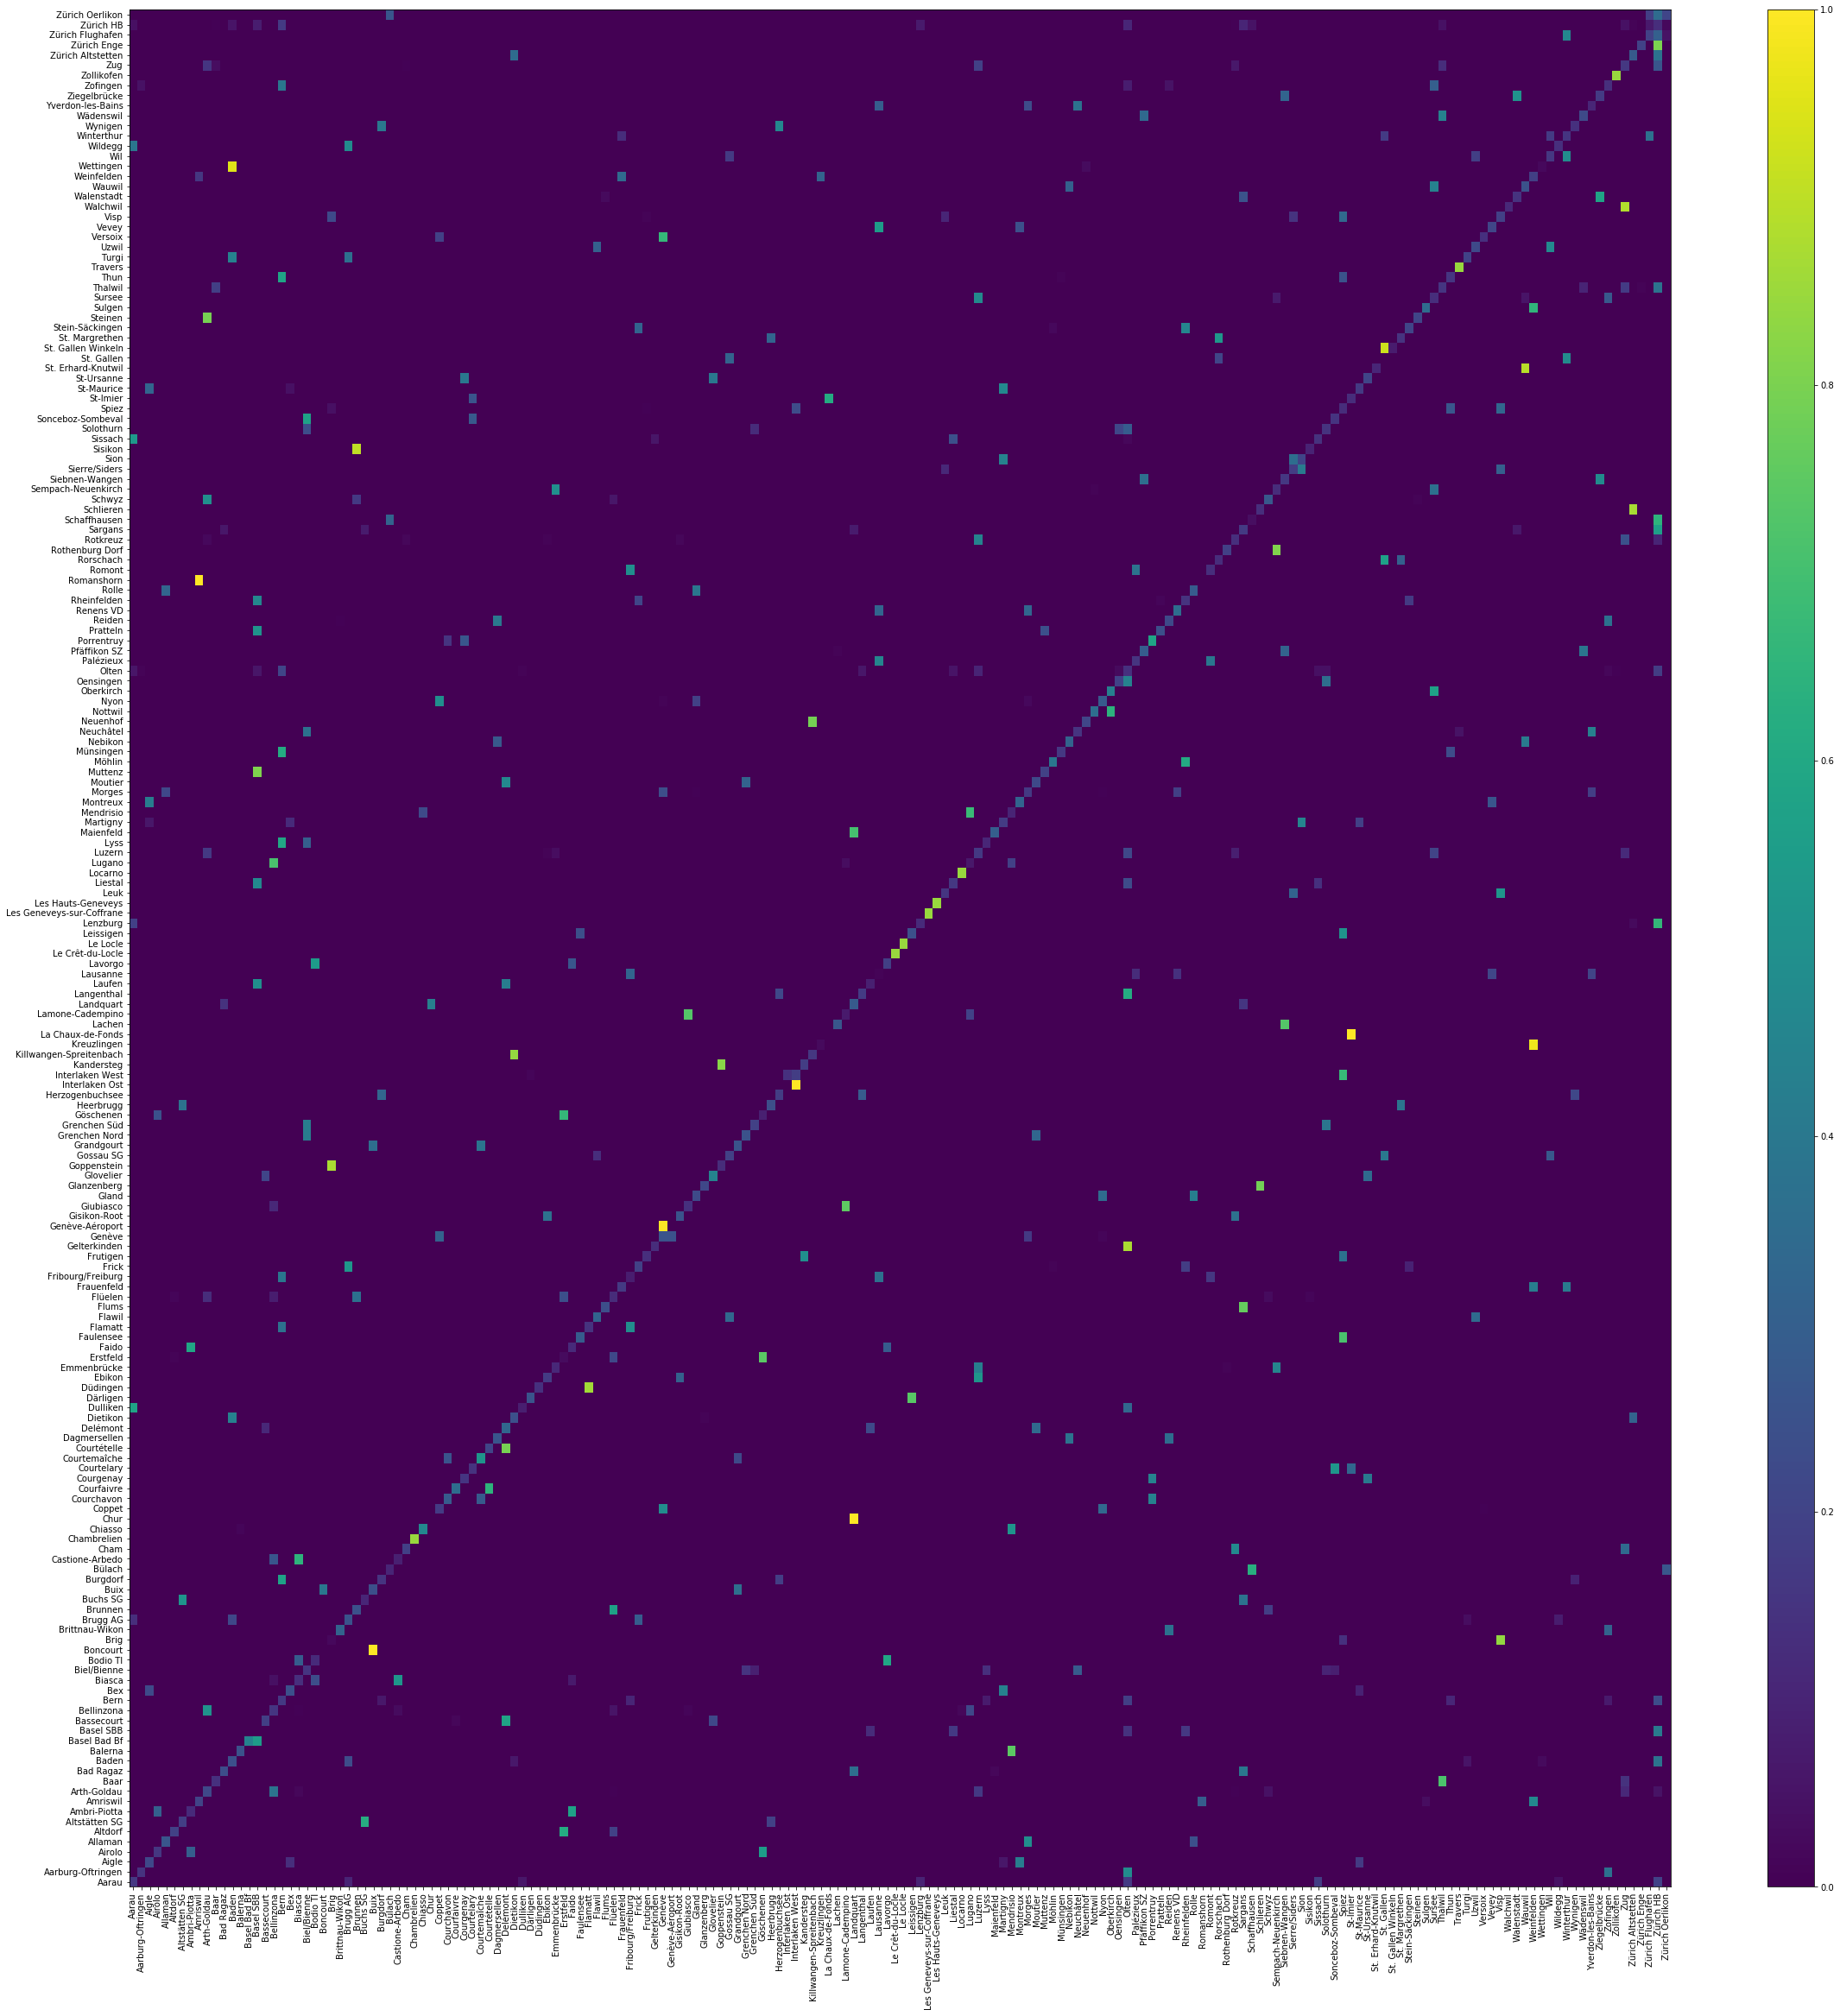

In [11]:
# Directed adjacency matrix
TM = TMs[0]
plt.figure(figsize=(40, 40))
plt.pcolor(TM)
plt.yticks(np.arange(0.5, states[0].shape[0], 1), TM.index)
plt.xticks(np.arange(0.5, states[0].shape[0], 1), TM.columns, rotation='vertical')
plt.colorbar(aspect=40)
plt.show()

## Analysis

In [12]:
from scipy.linalg import norm
import time

In [13]:
def simulate_markov(TM, verbose='on'):
    e1 = time.time()
    states_n = TM.shape[0]
    pi = np.ones(states_n)
    pi1 = np.zeros(states_n)
    pi = np.random.rand(states_n)
    pi = pi / pi.sum()

    n = norm(pi - pi1)
    i = 0
    diff = []
    while n > 1e-6 and i < 1 * 1e4:
        pi1 = TM.T.dot(pi).copy()
        n = norm(pi - pi1)
        i += 1
        diff.append(n)
        pi = pi1.copy()
    if verbose == 'on':
        print("Iterating {} times in {}".format(i, time.time() - e1))

    mixing_ = i

    return pi1, mixing_

In [14]:
# We run the power iteration for several times to see if there are some variations in the mixing time
mixing = []

for TM in TMs:
    n = 100
    Mixing_times_n_times = np.zeros((n, 1))
    for i in range(n):
        t, mixing_ = simulate_markov(TM, verbose='off')
        Mixing_times_n_times[i] = mixing_
    mixing.append(Mixing_times_n_times)

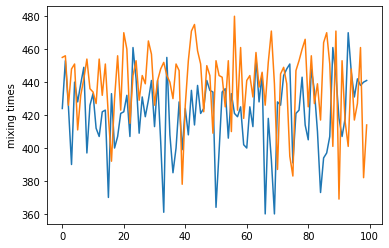

In [15]:
for mix in mixing:
    plt.plot(mix)
plt.ylabel('mixing times')
plt.show()

In [16]:
def Kemeny_constant(MC):
    from scipy.linalg import eig
    eigval, vl, vr = eig(MC, left=True)
    eigval = np.real(eigval)
    vl = np.real(vl)

    eigvec_1 = vl[:, np.argmax(np.abs(
        eigval))] / vl[:, np.argmax(np.abs(eigval))].sum()
    ind = np.around(eigval, decimals=8) != 1
    return np.divide(1, (1 - eigval[ind])).sum(), eigvec_1

In [17]:
Kemenys = []
pi_list = []

for TM in TMs:
    A = TM.values
    K, pi = Kemeny_constant(A)
    print(K, np.sum(pi))
    Kemenys.append(K)
    pi_list.append(pi)

642.2298484044031 0.9999999999999998
649.4667869544352 1.0


In [18]:
# Steady distribution of stations
steady_states = []

for i, initial in enumerate(initials):
    Steady_dist = initial
    Steady_dist['Pi'] = pi_list[i]
    steady_states.append(Steady_dist)

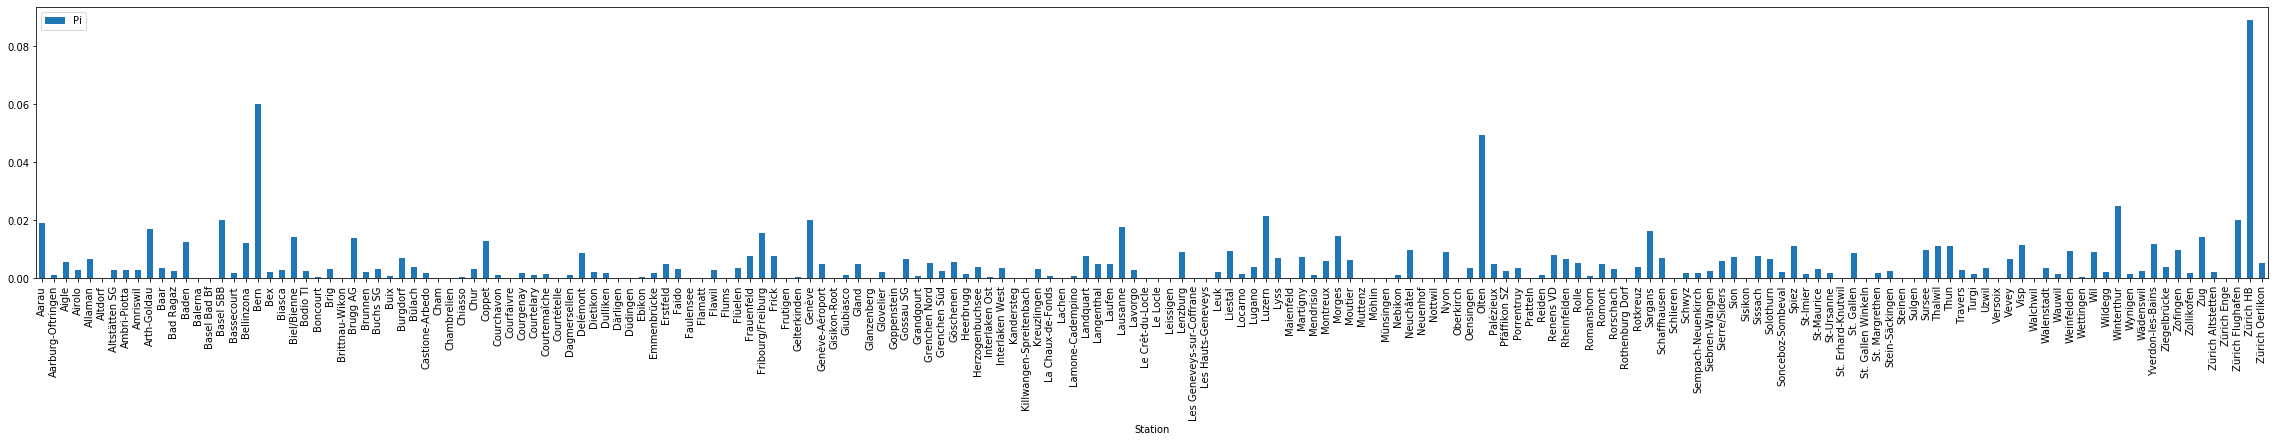

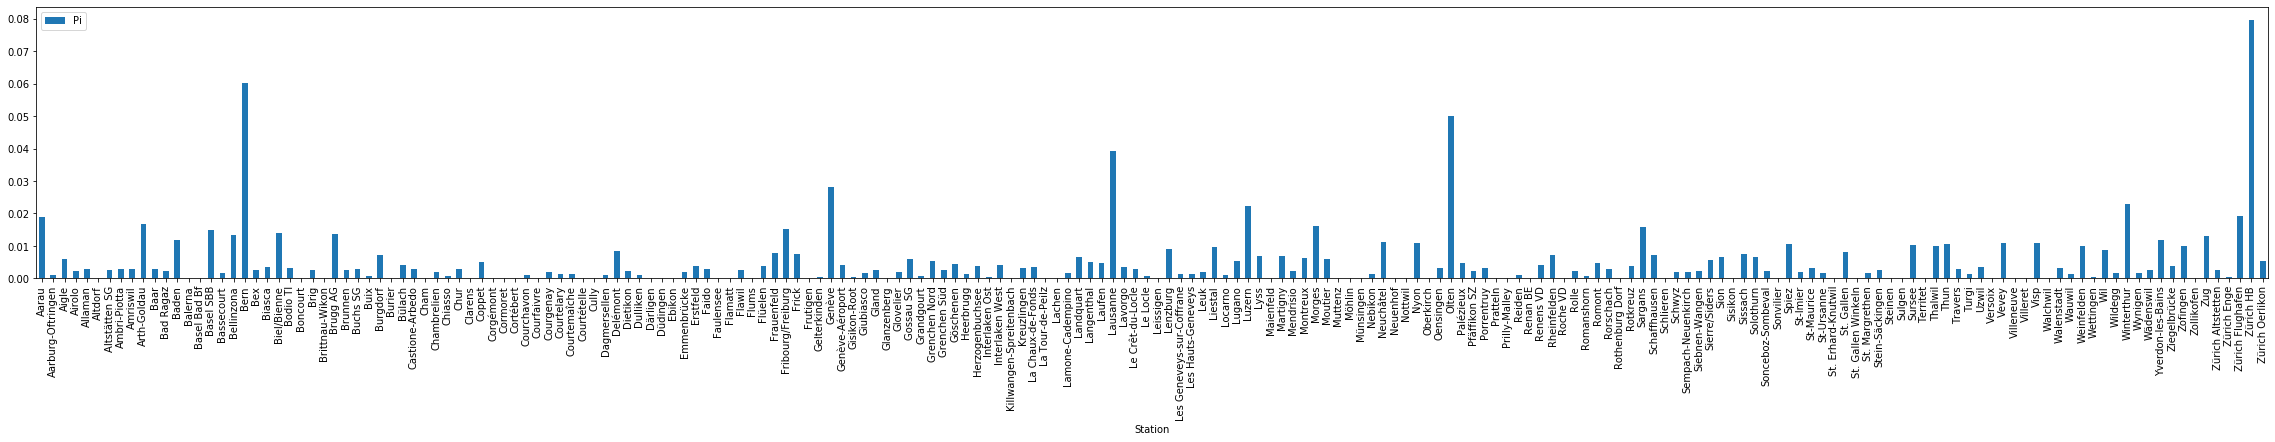

In [19]:
for steady in steady_states:
    steady.plot.bar(x='Station', y='Pi', figsize=(40, 5));

## Results

In [20]:
# Compute rankings
stationranks = []

for steady in steady_states:
    stationrank = steady.sort_values(['Pi'], ascending=False)
    stationrank = stationrank[['Station', 'Pi', 'Prob']]
    stationranks.append(stationrank)

In [21]:
# Day 1
stationranks[0]

Station        Pi      Prob
184                Zürich HB  0.089267  0.141975
18                      Bern  0.060306  0.058361
120                    Olten  0.049568  0.037037
173               Winterthur  0.024904  0.001684
102                   Luzern  0.021487  0.061728
..                       ...       ...       ...
82   Killwangen-Spreitenbach  0.000024  0.000000
150       St. Erhard-Knutwil  0.000021  0.000000
115                 Neuenhof  0.000019  0.000000
13                   Balerna  0.000017  0.000000
14              Basel Bad Bf  0.000010  0.000561

[186 rows x 3 columns]

In [22]:
# Day 2
stationranks[1]

Station        Pi      Prob
196                Zürich HB  0.079710  0.148923
18                      Bern  0.060192  0.068308
125                    Olten  0.050149  0.038154
95                  Lausanne  0.039227  0.026462
70                    Genève  0.028301  0.024000
..                       ...       ...       ...
86   Killwangen-Spreitenbach  0.000017  0.000000
41                  Cormoret  0.000016  0.000000
132                 Renan BE  0.000015  0.000000
14              Basel Bad Bf  0.000005  0.003692
191               Zollikofen  0.000003  0.001231

[198 rows x 3 columns]

## Network Visualization

In [23]:
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [24]:
TM = TMs[0]

In [25]:
# Construct the graph
G = nx.MultiDiGraph()
labels = {}
edge_labels = {}

for i, origin_state in enumerate(list(TM.index)):
    for j, destination_state in enumerate(list(TM.columns)):
        rate = TM.iloc[i, j]
        if rate > 0:
            G.add_edge(
                origin_state,
                destination_state,
                weight=rate,
                label="{:.02f}".format(rate))
            edge_labels[(origin_state,
                         destination_state)] = label = "{:.02f}".format(rate)

### Node attributes

In [26]:
bond = np.array(list(nx.get_edge_attributes(G,'weight').values()))

In [27]:
attrs = steady_states[0].set_index('Station').T.to_dict()

In [28]:
# Set pagerank metrics on each node,
nx.set_node_attributes(G, attrs)
pi = np.array(list(nx.get_node_attributes(G,'Pi').values()))

### Layout

In [29]:
pos = nx.spring_layout(G, seed=0)

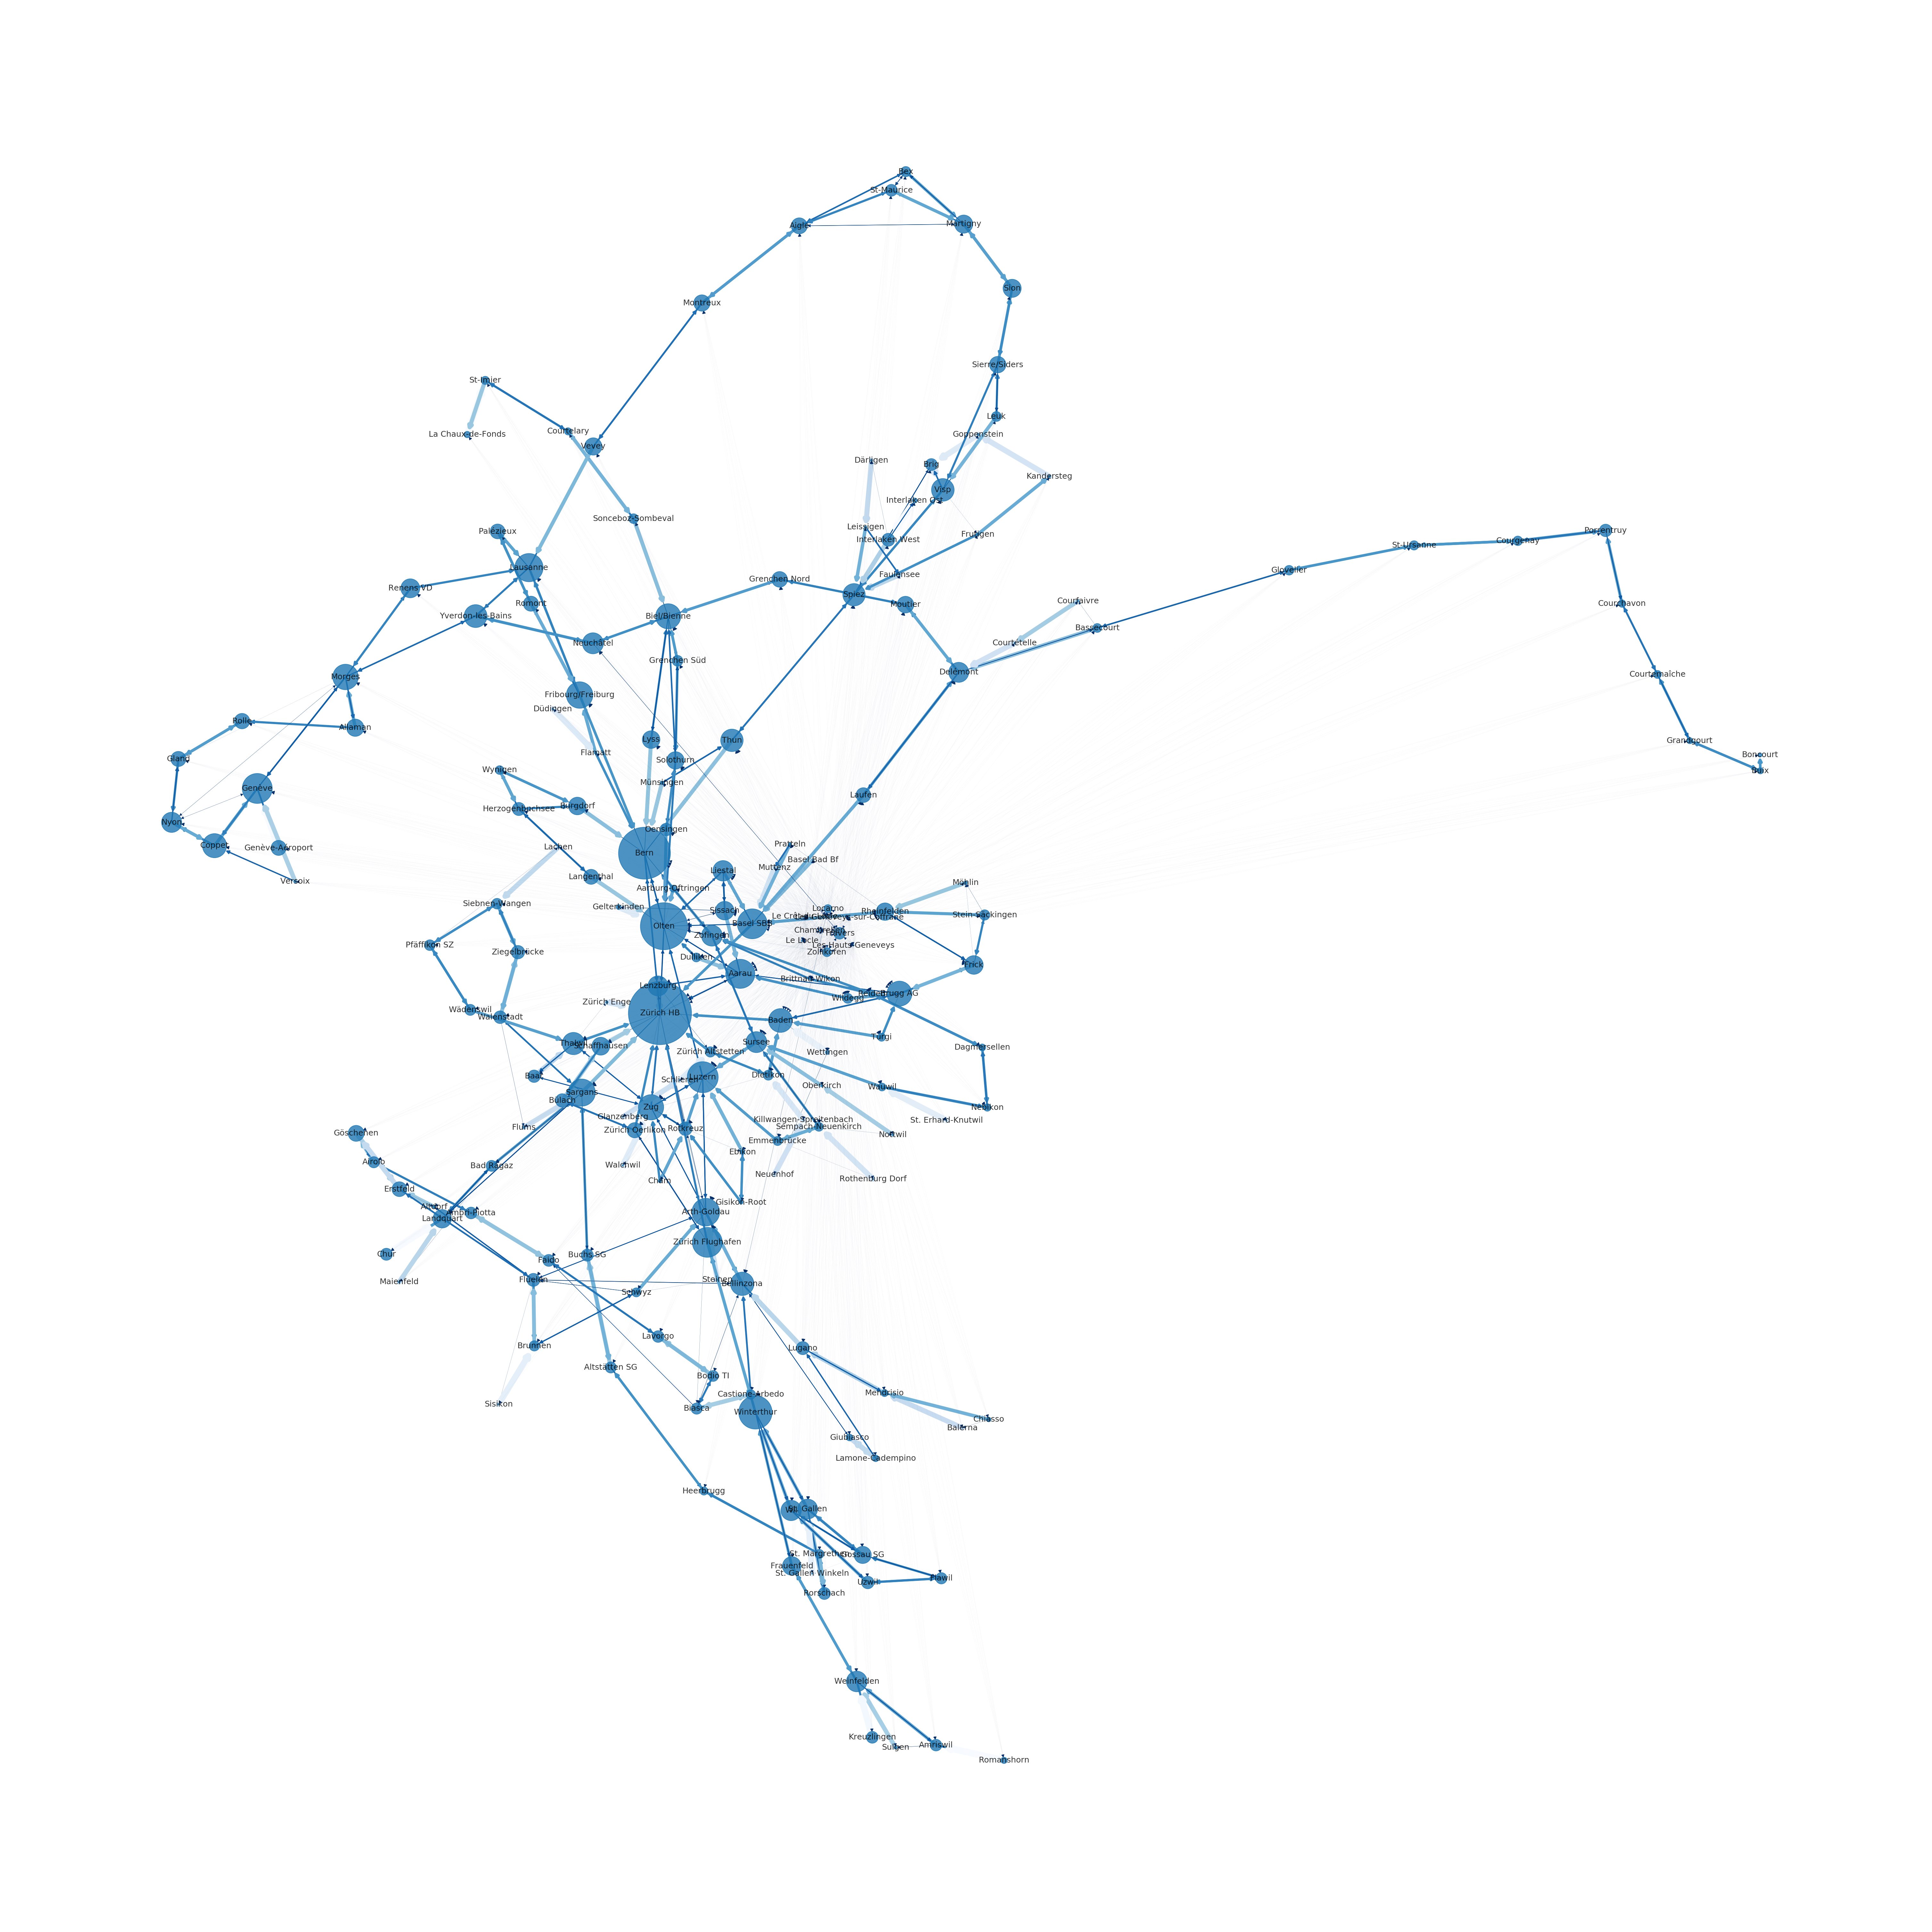

In [30]:
plt.figure(figsize = (40,40), dpi=150)
nx.draw(G, pos=pos, edge_color=bond,
        edge_cmap=plt.cm.Blues_r, with_labels=True, font_weight=2,
        node_size=pi*pow(10,5), width=bond*10, alpha=0.8)

## Export the Graph

In [31]:
# Write to file for further visualization
from networkx.drawing.nx_agraph import write_dot
import pygraphviz
write_dot(G, 'data/mc.dot')

[See visualization here](https://nbviewer.jupyter.org/github/GAnagno/Social-Web/blob/master/data/sbb/Star1.png)